- обход parent-left-right (pre-order)
- обход left-right-parent (post-order)
- обход left-parent-right (in-order)

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
import networkx as nx

In [2]:
class TreeNode:
    def __init__(self, num=None):
        self.key = self.num = num
        self.left = self.right = None

    def __repr__(self):
        return '["{}" {},{}]'.format(
            self.key,
            '.' if self.left is None else self.left.key,
            '.' if self.right is None else self.right.key,
        )


def read_graph(nodes):
    if isinstance(nodes, str):
        nodes = nodes.split(';')
    graph = [TreeNode() for _ in range(len(nodes))]
    for num, node in enumerate(nodes):
        if isinstance(node, str):
            key, left, right = map(int, node.strip().split())
        graph[num].num = num
        graph[num].key = key
        if left != -1:
            graph[num].left = graph[left]
        if right != -1:
            graph[num].right = graph[right]
    return graph[0]


def draw_tree(tree, root=0,
              width=.05, vgap=.05, vloc=0, xcenter=.5,
              node_color='lightgray', node_size=600,
              **kw):
    def add_node(node):
        num = node.num
        if num not in graph.nodes:
            graph.add_node(num)
            labels[num] = node.key
        if node.left is not None:
            add_node(node.left)
            graph.add_edge(num, node.left.num)
        if node.right is not None:
            add_node(node.right)
            graph.add_edge(num, node.right.num)

    graph = nx.Graph()
    labels = {}
    add_node(tree)

    def layout_hier(root, width, vloc, xcenter, pos=None, parent=None):
        if pos is None:
            pos = { root: (xcenter, vloc) }
        else:
            pos[root] = (xcenter, vloc)
        neighbors = list(graph.neighbors(root))
        if parent is not None:
            neighbors.remove(parent)
        if len(neighbors):
            dx = width / len(neighbors) 
            nextx = xcenter - width/2 - dx/2
            for neighbor in neighbors:
                nextx += dx
                pos = layout_hier(neighbor, width=dx, vloc=vloc-vgap, xcenter=nextx,
                                  pos=pos, parent=root)
        return pos

    pos = layout_hier(root, width, vloc, xcenter)
    return nx.draw(graph, pos=pos, with_labels=True, labels=labels,
                   node_color=node_color, node_size=node_size,
                   **kw)

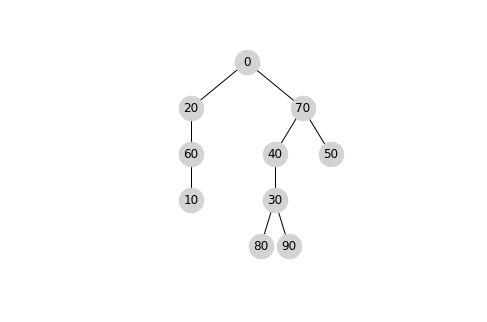

In [3]:
tree = read_graph('0 7 2;10 -1 -1;20 -1 6;30 8 9;40 3 -1;50 -1 -1;60 1 -1;70 5 4;80 -1 -1;90 -1 -1')
draw_tree(tree)

In [4]:
# in_order: left,parent,right
def in_order_rec(tree):
    if tree:
        yield from in_order_rec(tree.left)
        yield tree.key
        yield from in_order_rec(tree.right)

# pre_order: parent,left,right
def pre_order_rec(tree):
    if tree:
        yield tree.key
        yield from pre_order_rec(tree.left)
        yield from pre_order_rec(tree.right)

# post_order: left,right,parent
def post_order_rec(tree):
    if tree:
        yield from post_order_rec(tree.left)
        yield from post_order_rec(tree.right)
        yield tree.key

def test_rec():
    tree = read_graph('4 1 2;2 3 4;5 -1 -1;1 -1 -1;3 -1 -1')
    assert list(in_order_rec(tree)) == [1,2,3,4,5]
    assert list(pre_order_rec(tree)) == [4,2,1,3,5]
    assert list(post_order_rec(tree)) == [1,3,2,5,4]
    print('ok')

test_rec()

ok


In [5]:
# in_order: left,parent,right
def in_order_seq(node):
    stack = []
    while node or stack:
        if node:
            stack.append(node)
            node = node.left
        else:
            node = stack.pop()
            yield node.key
            node = node.right

# pre_order: parent,left,right
def pre_order_seq(node):
    stack = []
    while node or stack:
        node = node or stack.pop()
        yield node.key
        if node.right:
            stack.append(node.right)
        node = node.left

# post_order: left,right,parent
def post_order_seq(node):
    stack = []
    while node or stack:
        if node:
            if node.right:
                stack.append(node.right)
            stack.append(node)
            node = node.left
            continue
        node = stack.pop()
        if stack and stack[-1] == node.right:
            stack[-1] = node
            node = node.right
        else:
            yield node.key
            node = None

def test_seq():
    tree = read_graph('4 1 2;2 3 4;5 -1 -1;1 -1 -1;3 -1 -1')
    assert list(in_order_seq(tree)) == [1,2,3,4,5]
    assert list(pre_order_seq(tree)) == [4,2,1,3,5]
    assert list(post_order_seq(tree)) == [1,3,2,5,4]

    tree = read_graph('0 7 2;10 -1 -1;20 -1 6;30 8 9;40 3 -1;50 -1 -1;60 1 -1;70 5 4;80 -1 -1;90 -1 -1')
    assert list(in_order_seq(tree)) == [50,70,80,30,90,40,0,20,10,60]
    assert list(pre_order_seq(tree)) == [0,70,50,40,30,80,90,20,60,10]
    assert list(post_order_seq(tree)) == [50,80,90,30,40,70,10,60,20,0]

    print('ok')

test_seq()

ok


In [6]:
%%writefile traverse-methods.py
from collections import namedtuple

TupleNode = namedtuple('TupleNode', ['key', 'left', 'right'])

def in_order(tree, node=0):
    stack = []
    while node >= 0 or stack:
        if node >= 0:
            stack.append(node)
            node = tree[node].left
        else:
            node = stack.pop()
            yield tree[node].key
            node = tree[node].right

def pre_order(tree, node=0):
    stack = []
    while node >= 0 or stack:
        if node < 0:
            node = stack.pop()
        yield tree[node].key
        if tree[node].right >= 0:
            stack.append(tree[node].right)
        node = tree[node].left

def post_order(tree, node=0):
    stack = []
    while node >= 0 or stack:
        if node >= 0:
            if tree[node].right >= 0:
                stack.append(tree[node].right)
            stack.append(node)
            node = tree[node].left
            continue
        node = stack.pop()
        if stack and stack[-1] == tree[node].right:
            stack[-1], node = node, stack[-1]
        else:
            yield tree[node].key
            node = -1

def main():
    num_nodes = int(input())
    tree = [TupleNode(*map(int, input().split()))
            for i in range(num_nodes)]
    print(*in_order(tree))
    print(*pre_order(tree))
    print(*post_order(tree))


main()

Overwriting traverse-methods.py


In [7]:
%%bash
python3 traverse-methods.py <<EOF
5
4 1 2
2 3 4
5 -1 -1
1 -1 -1
3 -1 -1
EOF
# expect:
# 1 2 3 4 5
# 4 2 1 3 5
# 1 3 2 5 4

1 2 3 4 5
4 2 1 3 5
1 3 2 5 4


In [8]:
%%bash
python3 traverse-methods.py <<EOF
10
0 7 2
10 -1 -1
20 -1 6
30 8 9
40 3 -1
50 -1 -1
60 1 -1
70 5 4
80 -1 -1
90 -1 -1
EOF
# expect:
# 50 70 80 30 90 40 0 20 10 60
# 0 70 50 40 30 80 90 20 60 10
# 50 80 90 30 40 70 10 60 20 0

50 70 80 30 90 40 0 20 10 60
0 70 50 40 30 80 90 20 60 10
50 80 90 30 40 70 10 60 20 0
